In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns

import datetime

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import cross_val_score

import lightgbm as lgb

In [2]:
path = "/Users/utotakahiro/Documents/GCI/competition3/"

df = pd.read_csv(path + 'train.csv')
df_test = pd.read_csv(path + 'test.csv')

In [3]:
print('訓練データのデータ数は{}、変数は{}種類です。'.format(df.shape[0], df.shape[1]))
print('テストデータのデータ数は{}、変数は{}種類です'.format(df_test.shape[0], df_test.shape[1]))

訓練データのデータ数は2882335、変数は6種類です。
テストデータのデータ数は214200、変数は3種類です


### カラム情報一覧
データに含まれるカラムの情報は以下です。
* index ... (店舗, 商品) の各組み合わせに対してわりふられるID
* store_id ... 店舗ID
* goods_id ... 商品ID
* goods_genre_id ... 商品カテゴリID
* units_sold_day ... 商品の一日の売り上げ個数
* units_sold_month ... 商品のひと月の売り上げ個数 (今回の予測のターゲット)
* price ... 商品の現在の値段
* yy-mm-dd ... 日付 (yy/mm/dd形式)
* num_month ... 便宜上各月にわりふられた値 (平成25年1月=1, 平成25年2月=2,...,平成27年9月=33)
* goods_name ... 商品名
* store_name ... 店舗名
* goods_genre_name ... 商品カテゴリ名

## EDA  
### 欠損値

In [4]:
df.isnull().sum() 

yy_mm_dd          0
num_month         0
store_id          0
goods_id          0
price             0
units_sold_day    0
dtype: int64

In [5]:
df_test.isnull().sum() 

index       0
store_id    0
goods_id    0
dtype: int64

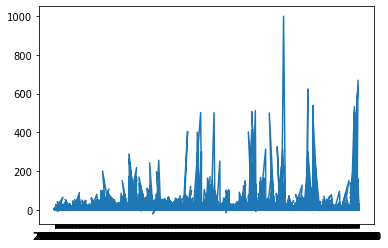

In [6]:
#for x in ['num_month', 'store_id', 'goods_id', 'price', 'units_sold_day']:
plt.plot(df['yy_mm_dd'],df['units_sold_day'])

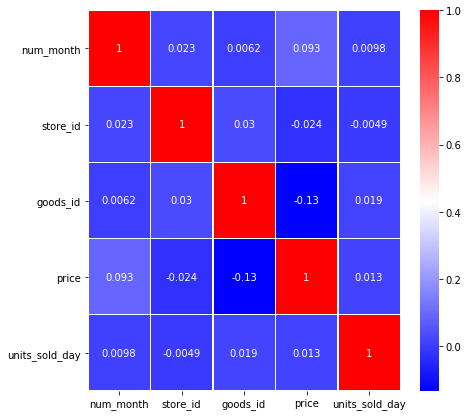

In [7]:
sns.heatmap(df.corr(),annot=True,cmap='bwr',linewidths=0.4)
fig=plt.gcf()
fig.set_size_inches(7,7)
plt.show()

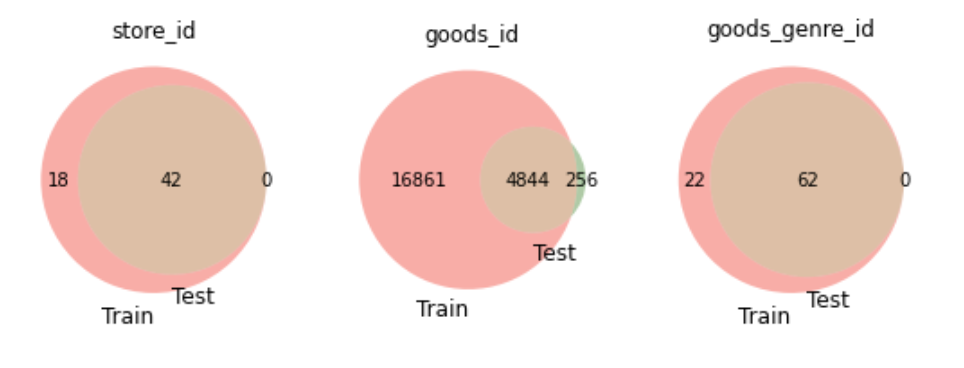

日付などの情報を取り出す

In [17]:
# 年月日を、年・月・日に分割
df['year'] = df['yy_mm_dd'].apply(lambda x: int(str(x)[0:2]))
df['month'] = df['yy_mm_dd'].apply(lambda x: int(str(x)[3:5]))
df['day'] = df['yy_mm_dd'].apply(lambda x: int(str(x)[6:]))

df.head()

,yy_mm_dd,num_month,store_id,goods_id,price,units_sold_day,year,month,day
0,25-01-29,-33,43,17718,44943,2,25,1,29
1,25-01-08,-33,32,8648,14949,1,25,1,8
2,25-01-16,-33,53,10168,30158,1,25,1,16
3,25-01-23,-33,31,1005,9922,1,25,1,23
4,25-01-12,-33,27,19861,14988,0,25,1,12


基準日を設定

In [18]:
# 基準日を2010年1月1日に設定
start_date = pd.Timestamp('2013-01-01')


# 基準日との差分を格納
df['total_days'] = df['yy_mm_dd'].apply(lambda x: (datetime.datetime(int(str(x)[0:2])+2000 - 12,int(str(x)[3:5]),int(str(x)[6:])) - start_date).days)

df.head(50)

,yy_mm_dd,num_month,store_id,goods_id,price,units_sold_day,year,month,day,total_days
0,25-01-29,-33,43,17718,44943,2,25,1,29,28
1,25-01-08,-33,32,8648,14949,1,25,1,8,7
2,25-01-16,-33,53,10168,30158,1,25,1,16,15
3,25-01-23,-33,31,1005,9922,1,25,1,23,22
4,25-01-12,-33,27,19861,14988,0,25,1,12,11
5,25-01-11,-33,26,18473,19768,1,25,1,11,10
6,25-01-09,-33,51,6096,170492,1,25,1,9,8
7,25-01-04,-33,7,13902,29793,1,25,1,4,3
8,25-01-10,-33,23,17213,15099,1,25,1,10,9
9,25-01-20,-33,47,15105,129142,1,25,1,20,19


In [19]:
#いらないカラムを消去
df.drop(['yy_mm_dd','num_month'],axis =1,inplace = True)

In [20]:
df.head()

,store_id,goods_id,price,units_sold_day,year,month,day,total_days
0,43,17718,44943,2,25,1,29,28
1,32,8648,14949,1,25,1,8,7
2,53,10168,30158,1,25,1,16,15
3,31,1005,9922,1,25,1,23,22
4,27,19861,14988,0,25,1,12,11


In [21]:
df.dtypes

store_id          int64
goods_id          int64
price             int64
units_sold_day    int64
year              int64
month             int64
day               int64
total_days        int64
dtype: object

In [22]:
#(df.groupby(['store_id','year','month'])['price'] *df.groupby(['store_id','year','month'])['units_sold_day']).sum()
df.groupby(['year','month'])['units_sold_day'].sum()

year  month
25    1        131514
      2        128111
      3        147108
      4        107218
      5        106958
      6        125363
      7        116959
      8        125245
      9        133320
      10       127562
      11       129969
      12       183339
26    1        116916
      2        109612
      3        115302
      4         96568
      5         97824
      6         97442
      7         91242
      8        102767
      9         99199
      10       107437
      11       117859
      12       168763
27    1        111006
      2         84165
      3         81989
      4         77813
      5         72233
      6         64091
      7         63159
      8         66034
      9         72851
Name: units_sold_day, dtype: int64

## ラグ特徴量をつくる  
25年1月から27年9月までのデータ。とりあえず27年の分を作ってみる。

In [23]:
df_27_9 = df[(df['year'] == 27) &(df['month'] == 9)].loc[:, ['store_id','goods_id','units_sold_day']]
df_27_9.groupby(['store_id','goods_id'])['units_sold_day'].sum()

store_id  goods_id
2         1289        1
          2064        1
          2864        1
          3028        1
          3342        2
                     ..
60        22088       3
          22089       1
          22092       3
          22101       1
          22139       1
Name: units_sold_day, Length: 32444, dtype: int64

In [24]:
def lag_feature(y,m):
    df_lag = df[(df['year'] == y) &(df['month'] == m)].loc[:, ['store_id','goods_id','units_sold_day']]
    se_lag = df_lag.groupby(['store_id','goods_id'])['units_sold_day'].sum()
    df_lag_1 = pd.DataFrame(list(se_lag.index),columns = ['store_id','goods_id'])
    df_lag_1[str(y)+'_'+str(m)] = se_lag.values
    
    return df_lag_1

In [25]:
lag_feature(27,8)

,store_id,goods_id,27_8
0,2,793,1
1,2,1467,2
2,2,1485,1
3,2,1496,2
4,2,1524,1
...,...,...,...
36530,60,22089,6
36531,60,22093,1
36532,60,22103,2
36533,60,22106,1


In [26]:
df_1 = df.drop(['price', 'units_sold_day', 'year', 'month','day', 'total_days'],axis = 1)
couple = df_1.groupby(['store_id','goods_id']).size().index.values
df_2 = pd.DataFrame(list(couple),columns = ['store_id','goods_id'])
df_2

,store_id,goods_id
0,1,30
1,1,31
2,1,32
3,1,33
4,1,34
...,...,...
503350,60,22156
503351,60,22163
503352,60,22164
503353,60,22165


In [27]:
df.columns

Index(['store_id', 'goods_id', 'price', 'units_sold_day', 'year', 'month',
       'day', 'total_days'],
      dtype='object')

In [28]:
df_all = pd.merge(df_2,lag_feature(27,1),how = 'outer').fillna(0)
df_all.head()

,store_id,goods_id,27_1
0,1,30,0.0
1,1,31,0.0
2,1,32,0.0
3,1,33,0.0
4,1,34,0.0


In [29]:
for i in range(2,10):
    df_all = df_all.merge(lag_feature(27,i),how = 'outer').fillna(0)

featre2では25年の分まで入れる。その後、  
1. 各年の10月のみ  
2. 26年より前は3ヶ月刻み  
を試す

In [30]:
# ２５年までの分全て
df_all_0 = df_all.merge(lag_feature(25,1),how = 'outer').fillna(0)

for i in range(25,27):
    for j in range(1,13):
        df_all_0 = df_all_0.merge(lag_feature(i,j),how = 'outer').fillna(0)
        
df_all_0.columns

Index(['store_id', 'goods_id', '27_1', '27_2', '27_3', '27_4', '27_5', '27_6',
       '27_7', '27_8', '27_9', '25_1', '25_2', '25_3', '25_4', '25_5', '25_6',
       '25_7', '25_8', '25_9', '25_10', '25_11', '25_12', '26_1', '26_2',
       '26_3', '26_4', '26_5', '26_6', '26_7', '26_8', '26_9', '26_10',
       '26_11', '26_12'],
      dtype='object')

In [31]:
# 10月ぶん追加
df_all_1 = df_all.merge(lag_feature(25,10),how = 'outer').fillna(0)

for i in range(25,27):
    df_all_1 = df_all_1.merge(lag_feature(i,10),how = 'outer').fillna(0)
        
df_all_1.head()

,store_id,goods_id,27_1,27_2,27_3,27_4,27_5,27_6,27_7,27_8,27_9,25_10,26_10
0,1,30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
df_all_2 = df_all_0.copy()
for y in [25,26]:
    df_all_2[str(y)+ '_spring'] = (df_all_2[str(y)+'_3'] + df_all_2[str(y)+'_4'] + df_all_2[str(y)+'_5'])/3
    df_all_2[str(y)+ '_summer'] = (df_all_2[str(y)+'_6'] + df_all_2[str(y)+'_7'] + df_all_2[str(y)+'_8'])/3
    df_all_2[str(y)+ '_fall'] = (df_all_2[str(y)+'_9'] + df_all_2[str(y)+'_10'] + df_all_2[str(y)+'_11'])/3
    df_all_2[str(y)+ '_winter'] = (df_all_2[str(y)+'_12'] + df_all_2[str(y)+'_1'] + df_all_2[str(y)+'_2'])/3
    
    lis_m = []
    for i in range(1,13):
        lis_m.append(str(y)+ '_' + str(i))
        
    df_all_2.drop(lis_m,axis = 1, inplace = True)
    
df_all_2.head()

,store_id,goods_id,27_1,27_2,27_3,27_4,27_5,27_6,27_7,27_8,27_9,25_spring,25_summer,25_fall,25_winter,26_spring,26_summer,26_fall,26_winter
0,1,30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0
1,1,31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.333333,0.0,0.0,0.0,0.0
2,1,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.000000,0.0,0.0,0.0,0.0
3,1,33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.666667,0.0,0.0,0.0,0.0
4,1,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.000000,0.0,0.0,0.0,0.0


In [33]:
#全て統合したものをつくる
df_all_a = df_all_0.copy()
for y in [25,26]:
    df_all_a[str(y)+ '_spring'] = (df_all_a[str(y)+'_3'] + df_all_a[str(y)+'_4'] + df_all_a[str(y)+'_5'])/3
    df_all_a[str(y)+ '_summer'] = (df_all_a[str(y)+'_6'] + df_all_a[str(y)+'_7'] + df_all_a[str(y)+'_8'])/3
    df_all_a[str(y)+ '_fall'] = (df_all_a[str(y)+'_9'] + df_all_a[str(y)+'_10'] + df_all_a[str(y)+'_11'])/3
    df_all_a[str(y)+ '_winter'] = (df_all_a[str(y)+'_12'] + df_all_a[str(y)+'_1'] + df_all_a[str(y)+'_2'])/3
    
df_all_a.columns

Index(['store_id', 'goods_id', '27_1', '27_2', '27_3', '27_4', '27_5', '27_6',
       '27_7', '27_8', '27_9', '25_1', '25_2', '25_3', '25_4', '25_5', '25_6',
       '25_7', '25_8', '25_9', '25_10', '25_11', '25_12', '26_1', '26_2',
       '26_3', '26_4', '26_5', '26_6', '26_7', '26_8', '26_9', '26_10',
       '26_11', '26_12', '25_spring', '25_summer', '25_fall', '25_winter',
       '26_spring', '26_summer', '26_fall', '26_winter'],
      dtype='object')

In [34]:
df_test.head()

,index,store_id,goods_id
0,0,3,15900
1,1,3,18326
2,2,3,5665
3,3,3,15859
4,4,3,8826


店の直前の期間の売り上げ平均のカラムをつくる

In [35]:
df['store_income'] = df['price']*df['units_sold_day']

In [36]:
income_mean_27_all = df[df['year']==27].groupby('store_id')['store_income'].sum()/9
df_income = pd.DataFrame(income_mean_27_all)
df_income = df_income.reset_index()
df_income = df_income.rename(columns = {'store_income':'store_income_27_all'})

In [37]:
df_all_0_1 = df_all_a.copy()
df_all_0_1 = pd.merge(df_all_0_1,df_income)
df_all_0_1.head(10000)

,store_id,goods_id,27_1,27_2,27_3,27_4,27_5,27_6,27_7,27_8,...,26_12,25_spring,25_summer,25_fall,25_winter,26_spring,26_summer,26_fall,26_winter,store_income_27_all
0,2,28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.333333,0.000000,0.000000,0.000000,0.0,5.783486e+06
1,2,30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.333333,0.000000,0.000000,0.000000,0.0,5.783486e+06
2,2,31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.333333,0.000000,0.0,1.666667,0.000000,0.000000,0.000000,0.0,5.783486e+06
3,2,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,2.666667,0.000000,0.000000,0.000000,0.0,5.783486e+06
4,2,33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,3.666667,0.000000,0.000000,0.000000,0.0,5.783486e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,4,4707,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,9.205340e+07
9996,4,4711,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.333333,0.333333,0.0,9.205340e+07
9997,4,4712,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.666667,0.000000,0.000000,0.000000,0.0,9.205340e+07
9998,4,4713,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.333333,0.666667,0.0,0.000000,0.333333,0.000000,0.000000,0.0,9.205340e+07


直前3ヶ月

In [38]:
income_mean_27_3 = df[(df['year']==27)& ((df['month']==6)| (df['month']==7) | (df['month']==8))].groupby('store_id')['store_income'].sum()/3
df_income = pd.DataFrame(income_mean_27_3)
df_income = df_income.reset_index()
df_income = df_income.rename(columns = {'store_income':'store_income_27_3month'})

In [39]:
df_all_0_2 = pd.merge(df_all_0_1,df_income)
df_all_0_2.head()

,store_id,goods_id,27_1,27_2,27_3,27_4,27_5,27_6,27_7,27_8,...,25_spring,25_summer,25_fall,25_winter,26_spring,26_summer,26_fall,26_winter,store_income_27_all,store_income_27_3month
0,2,28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,5.783486e+06,5.278047e+06
1,2,30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,5.783486e+06,5.278047e+06
2,2,31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.333333,0.0,0.0,1.666667,0.0,0.0,0.0,0.0,5.783486e+06,5.278047e+06
3,2,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,2.666667,0.0,0.0,0.0,0.0,5.783486e+06,5.278047e+06
4,2,33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,3.666667,0.0,0.0,0.0,0.0,5.783486e+06,5.278047e+06


## Base line model

最新月の9月をyのデータに割り当てる

In [40]:
df_all.head()

,store_id,goods_id,27_1,27_2,27_3,27_4,27_5,27_6,27_7,27_8,27_9
0,1,30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
X = df_all.iloc[:,:10].values
y = df_all.iloc[:,10:].T.values

X_test = df_test.iloc[:, 1:].values

y = y[0]

In [42]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [43]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

In [44]:
lgbm_params = {
        # 回帰問題
        'objective': 'regression',
        # RMSE (平均二乗誤差平方根) の最小化を目指す
        'metric': 'rmse',
}

In [45]:
model = lgb.train(lgbm_params, lgb_train, valid_sets=lgb_eval)

[1]	valid_0's rmse: 2.04822
[2]	valid_0's rmse: 1.96491
[3]	valid_0's rmse: 1.89293
[4]	valid_0's rmse: 1.8374
[5]	valid_0's rmse: 1.8074
[6]	valid_0's rmse: 1.76222
[7]	valid_0's rmse: 1.75149
[8]	valid_0's rmse: 1.71984
[9]	valid_0's rmse: 1.70051
[10]	valid_0's rmse: 1.69819
[11]	valid_0's rmse: 1.6816
[12]	valid_0's rmse: 1.68233
[13]	valid_0's rmse: 1.68738
[14]	valid_0's rmse: 1.6993
[15]	valid_0's rmse: 1.69442
[16]	valid_0's rmse: 1.6878
[17]	valid_0's rmse: 1.69559
[18]	valid_0's rmse: 1.69867
[19]	valid_0's rmse: 1.69872
[20]	valid_0's rmse: 1.71421
[21]	valid_0's rmse: 1.71524
[22]	valid_0's rmse: 1.72349
[23]	valid_0's rmse: 1.73376
[24]	valid_0's rmse: 1.75579
[25]	valid_0's rmse: 1.76344
[26]	valid_0's rmse: 1.76346
[27]	valid_0's rmse: 1.76957
[28]	valid_0's rmse: 1.79287
[29]	valid_0's rmse: 1.79308
[30]	valid_0's rmse: 1.80494
[31]	valid_0's rmse: 1.80538
[32]	valid_0's rmse: 1.80538
[33]	valid_0's rmse: 1.84689
[34]	valid_0's rmse: 1.87485
[35]	valid_0's rmse: 1.88015

In [46]:
y_pred = model.predict(X_valid)

# RMSE を計算する
mse = mean_squared_error(y_valid, y_pred)
rmse = np.sqrt(mse)
print(rmse)

2.0534440852768423


In [47]:
lgbm_cross = lgb.LGBMRegressor()

In [48]:
# k分割交差検証の実行
scores = -cross_val_score(lgbm_cross, X, y, cv=20, scoring= 'neg_root_mean_squared_error')

# 結果の表示
print('Cross validation scores: {}'.format(scores))
print('Cross validation scores: {:.3f}+-{:.3f}'.format(scores.mean(), scores.std()))

#値が大きい方が優れる様になっているから、負の値をかけて補正した。

Cross validation scores: [ 0.76181759  1.81460624 10.43042181  2.26500376  2.05727942  1.43034229
  1.27080458  2.43797371  2.52060561  0.95061415  2.76253997  1.5036197
  1.37794445  2.43119184  0.9016354   1.50215602  1.43449275  1.5289467
 12.52665736  3.21366355]
Cross validation scores: 2.756+-2.995


全て入れる（ver0）

In [49]:
df_all_0.head()

,store_id,goods_id,27_1,27_2,27_3,27_4,27_5,27_6,27_7,27_8,...,26_3,26_4,26_5,26_6,26_7,26_8,26_9,26_10,26_11,26_12
0,1,30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
X_0 = df_all_0.iloc[:,:26].values
y_0 = df_all_0.iloc[:,26:].T.values
y_0 = y_0[0]

# k分割交差検証の実行
scores = -cross_val_score(lgbm_cross, X_0, y_0, cv=20, scoring= 'neg_root_mean_squared_error')

# 結果の表示
print('Cross validation scores: {}'.format(scores))
print('Cross validation scores: {:.3f}+-{:.3f}'.format(scores.mean(), scores.std()))

#値が大きい方が優れる様になっているから、負の値をかけて補正した。

Cross validation scores: [0.81741321 2.09404621 1.41394677 1.10604064 1.29656097 1.2405638
 1.32490111 1.93672131 5.86290273 2.078701   2.88128962 0.81912582
 1.01644188 1.99682556 1.12947664 0.91247894 0.95710763 2.95888583
 0.94085329 1.04858681]
Cross validation scores: 1.692+-1.145


10月のみ

In [51]:
df_all_1.head()

,store_id,goods_id,27_1,27_2,27_3,27_4,27_5,27_6,27_7,27_8,27_9,25_10,26_10
0,1,30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
X_1 = df_all_1.drop('27_9',axis=1).values
y_1 = df_all_1['27_9'].values


# k分割交差検証の実行
scores = -cross_val_score(lgbm_cross, X_1, y_1, cv=20, scoring= 'neg_root_mean_squared_error')

# 結果の表示
print('Cross validation scores: {}'.format(scores))
print('Cross validation scores: {:.3f}+-{:.3f}'.format(scores.mean(), scores.std()))

#値が大きい方が優れる様になっているから、負の値をかけて補正した。

Cross validation scores: [ 0.74102008  1.87626648 10.26070148  1.86440195  2.10411123  1.27027831
  1.29501947  2.41237123  2.65398268  0.9628067   2.61824084  1.71223276
  1.22239602  2.50276937  0.71923898  1.43158216  1.17161307  1.49691388
 12.47709186  3.36090197]
Cross validation scores: 2.708+-2.987


３ヶ月ごと

In [53]:
df_all_2.head()

,store_id,goods_id,27_1,27_2,27_3,27_4,27_5,27_6,27_7,27_8,27_9,25_spring,25_summer,25_fall,25_winter,26_spring,26_summer,26_fall,26_winter
0,1,30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0
1,1,31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.333333,0.0,0.0,0.0,0.0
2,1,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.000000,0.0,0.0,0.0,0.0
3,1,33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.666667,0.0,0.0,0.0,0.0
4,1,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.000000,0.0,0.0,0.0,0.0


In [54]:
X_2 = df_all_2.drop('27_9',axis=1).values
y_2 = df_all_2['27_9'].values

# k分割交差検証の実行
scores = -cross_val_score(lgbm_cross, X_2, y_2, cv=20, scoring= 'neg_root_mean_squared_error')

# 結果の表示
print('Cross validation scores: {}'.format(scores))
print('Cross validation scores: {:.3f}+-{:.3f}'.format(scores.mean(), scores.std()))

#値が大きい方が優れる様になっているから、負の値をかけて補正した。

Cross validation scores: [ 0.71809661  1.60544808 10.21873775  2.01857242  1.83024067  1.27237277
  1.33602029  2.67130972  2.61272246  0.72276363  2.69378662  1.79591649
  1.73874404  2.63816375  0.82830281  1.32390538  0.81035961  1.32491592
 12.45150264  3.27261646]
Cross validation scores: 2.694+-2.989


全て統合したもの

In [55]:
X_a = df_all_a.drop('27_9',axis=1).values
y_a = df_all_a['27_9'].values

# k分割交差検証の実行
scores = -cross_val_score(lgbm_cross, X_a, y_a, cv=20, scoring= 'neg_root_mean_squared_error')

# 結果の表示
print('Cross validation scores: {}'.format(scores))
print('Cross validation scores: {:.3f}+-{:.3f}'.format(scores.mean(), scores.std()))

#値が大きい方が優れる様になっているから、負の値をかけて補正した。

Cross validation scores: [ 0.72706649  1.45639608 10.38482619  2.31801256  2.04136247  1.24657342
  1.30251654  2.71556264  2.26115711  0.68822569  2.58441552  2.06948885
  1.59756721  2.7930772   1.1166816   1.28036312  0.97380993  1.45365055
 12.48250472  3.14535659]
Cross validation scores: 2.732+-3.000


store_incomeも入れたもの

In [56]:
X_0_1 = df_all_0_1.drop('27_9',axis=1).values
y_0_1 = df_all_0_1['27_9'].values

# k分割交差検証の実行
scores = -cross_val_score(lgbm_cross, X_0_1, y_0_1, cv=20, scoring= 'neg_root_mean_squared_error')

# 結果の表示
print('Cross validation scores: {}'.format(scores))
print('Cross validation scores: {:.3f}+-{:.3f}'.format(scores.mean(), scores.std()))

#値が大きい方が優れる様になっているから、負の値をかけて補正した。

Cross validation scores: [ 0.85925226  1.51080809 10.29299621  2.19745762  1.40732462  1.33649772
  1.36606363  2.75425773  2.42093448  0.69110246  2.79027883  1.79289308
  2.17686401  2.81940708  1.47069591  1.4142143   0.83648847  1.66632537
 12.59607342  3.00247703]
Cross validation scores: 2.770+-2.991


store_income 3month ver も追加

In [57]:
X_0_2 = df_all_0_2.drop('27_9',axis=1).values
y_0_2 = df_all_0_2['27_9'].values

# k分割交差検証の実行
scores = -cross_val_score(lgbm_cross, X_0_2, y_0_2, cv=20, scoring= 'neg_root_mean_squared_error')

# 結果の表示
print('Cross validation scores: {}'.format(scores))
print('Cross validation scores: {:.3f}+-{:.3f}'.format(scores.mean(), scores.std()))

#値が大きい方が優れる様になっているから、負の値をかけて補正した。

Cross validation scores: [ 0.85327148  1.58949558 10.3555457   2.13346357  1.34966463  1.40552403
  1.38711723  3.08041035  2.23505472  0.70263844  3.10624897  1.70212382
  2.3013922   2.66602722  1.38481936  1.4373483   0.80088317  1.54351287
 12.4329917   3.06426221]
Cross validation scores: 2.777+-2.979


テストデータにも

In [58]:
df_test

,index,store_id,goods_id
0,0,3,15900
1,1,3,18326
2,2,3,5665
3,3,3,15859
4,4,3,8826
...,...,...,...
214195,214195,60,8851
214196,214196,60,1539
214197,214197,60,13719
214198,214198,60,6074


In [59]:
df_test_1 = pd.merge(df_test,df_all_0_1,how = 'left')
df_test_1

,index,store_id,goods_id,27_1,27_2,27_3,27_4,27_5,27_6,27_7,...,26_12,25_spring,25_summer,25_fall,25_winter,26_spring,26_summer,26_fall,26_winter,store_income_27_all
0,0,3,15900,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,1.102621e+08
1,1,3,18326,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,3,5665,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,2.333333,0.666667,0.333333,0.000000,1.0,1.102621e+08
3,3,3,15859,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,1.102621e+08
4,4,3,8826,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,214195,60,8851,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
214196,214196,60,1539,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,1.093361e+08
214197,214197,60,13719,0.0,0.0,0.0,0.0,0.0,2.0,6.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,1.093361e+08
214198,214198,60,6074,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.333333,0.333333,0.0,1.093361e+08


In [60]:
X_test_1 = df_test_1.iloc[:, 1:].values

In [61]:
X_train, X_valid, y_train, y_valid = train_test_split(X_0_2, y_0_2, test_size=0.3, random_state=42)

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

In [62]:
model = lgb.train(lgbm_params, lgb_train, valid_sets=lgb_eval)

[1]	valid_0's rmse: 5.85801
[2]	valid_0's rmse: 5.82297
[3]	valid_0's rmse: 5.79198
[4]	valid_0's rmse: 5.76025
[5]	valid_0's rmse: 5.73665
[6]	valid_0's rmse: 5.67675
[7]	valid_0's rmse: 5.62528
[8]	valid_0's rmse: 5.55651
[9]	valid_0's rmse: 5.54393
[10]	valid_0's rmse: 5.52168
[11]	valid_0's rmse: 5.47197
[12]	valid_0's rmse: 5.43082
[13]	valid_0's rmse: 5.42562
[14]	valid_0's rmse: 5.4078
[15]	valid_0's rmse: 5.39219
[16]	valid_0's rmse: 5.38877
[17]	valid_0's rmse: 5.38656
[18]	valid_0's rmse: 5.3873
[19]	valid_0's rmse: 5.38212
[20]	valid_0's rmse: 5.34572
[21]	valid_0's rmse: 5.3522
[22]	valid_0's rmse: 5.35533
[23]	valid_0's rmse: 5.35366
[24]	valid_0's rmse: 5.35597
[25]	valid_0's rmse: 5.35915
[26]	valid_0's rmse: 5.36297
[27]	valid_0's rmse: 5.3725
[28]	valid_0's rmse: 5.34155
[29]	valid_0's rmse: 5.34604
[30]	valid_0's rmse: 5.34539
[31]	valid_0's rmse: 5.34856
[32]	valid_0's rmse: 5.34787
[33]	valid_0's rmse: 5.34701
[34]	valid_0's rmse: 5.348
[35]	valid_0's rmse: 5.34461


In [63]:
y_pred = model.predict(X_valid)

# RMSE を計算する
mse = mean_squared_error(y_valid, y_pred)
rmse = np.sqrt(mse)
print(rmse)

5.362886219718849


score:6.92386

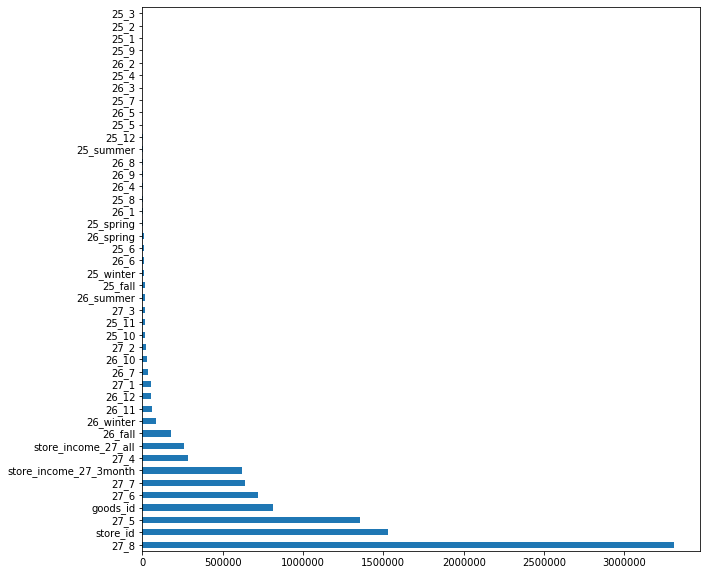

In [66]:
feature_scores = pd.Series(model.feature_importance(importance_type='gain'), index=df_all_0_2.drop('27_9',axis=1).columns).sort_values(ascending=False)

se = feature_scores
se.plot(kind='barh',figsize=(10, 10))

store_income_27_3monthも導入
testデータ用に、7~9月分と4~9月分のデータをつくる

In [74]:
#テストデータ用に３ヶ月をずらす
income_mean_27_3_test = df[(df['year']==27)& ((df['month']==7)| (df['month']==8) | (df['month']==9))].groupby('store_id')['store_income'].sum()/3
df_income_test_3 = pd.DataFrame(income_mean_27_3_test)
df_income_test_3 = df_income_test_3.reset_index()
df_income_test_3 = df_income_test_3.rename(columns = {'store_income':'store_income_27_3month_test'})

In [75]:
df_all_0_3 = pd.merge(df_all_0_1,df_income_test_3)
df_all_0_3.head()

,store_id,goods_id,27_1,27_2,27_3,27_4,27_5,27_6,27_7,27_8,...,25_spring,25_summer,25_fall,25_winter,26_spring,26_summer,26_fall,26_winter,store_income_27_all,store_income_27_3month_test
0,2,28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,5.783486e+06,4.827756e+06
1,2,30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,5.783486e+06,4.827756e+06
2,2,31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.333333,0.0,0.0,1.666667,0.0,0.0,0.0,0.0,5.783486e+06,4.827756e+06
3,2,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,2.666667,0.0,0.0,0.0,0.0,5.783486e+06,4.827756e+06
4,2,33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,3.666667,0.0,0.0,0.0,0.0,5.783486e+06,4.827756e+06


In [76]:
#テストデータ用6ヶ月をずらす
income_mean_27_6_test = df[(df['year']==27)& ((df['month']==7)| (df['month']==8) | (df['month']==9)| (df['month']==4)| (df['month']==5) | (df['month']==6))].groupby('store_id')['store_income'].sum()/6
df_income_test_6 = pd.DataFrame(income_mean_27_6_test)
df_income_test_6 = df_income_test_6.reset_index()
df_income_test_6 = df_income_test_6.rename(columns = {'store_income':'store_income_27_6month_test'})

In [78]:
df_all_0_4 = pd.merge(df_all_0_3,df_income_test_6)
df_all_0_4.head()

,store_id,goods_id,27_1,27_2,27_3,27_4,27_5,27_6,27_7,27_8,...,25_summer,25_fall,25_winter,26_spring,26_summer,26_fall,26_winter,store_income_27_all,store_income_27_3month_test,store_income_27_6month_test
0,2,28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,5.783486e+06,4.827756e+06,6327713.5
1,2,30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,5.783486e+06,4.827756e+06,6327713.5
2,2,31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.666667,0.0,0.0,0.0,0.0,5.783486e+06,4.827756e+06,6327713.5
3,2,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.666667,0.0,0.0,0.0,0.0,5.783486e+06,4.827756e+06,6327713.5
4,2,33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.666667,0.0,0.0,0.0,0.0,5.783486e+06,4.827756e+06,6327713.5


In [82]:
df_test_3 = pd.merge(df_test,df_all_0_4,how = 'left')
df_test_3.columns

Index(['index', 'store_id', 'goods_id', '27_1', '27_2', '27_3', '27_4', '27_5',
       '27_6', '27_7', '27_8', '27_9', '25_1', '25_2', '25_3', '25_4', '25_5',
       '25_6', '25_7', '25_8', '25_9', '25_10', '25_11', '25_12', '26_1',
       '26_2', '26_3', '26_4', '26_5', '26_6', '26_7', '26_8', '26_9', '26_10',
       '26_11', '26_12', '25_spring', '25_summer', '25_fall', '25_winter',
       '26_spring', '26_summer', '26_fall', '26_winter', 'store_income_27_all',
       'store_income_27_3month_test', 'store_income_27_6month_test'],
      dtype='object')

In [83]:
df_all_0_4.columns

Index(['store_id', 'goods_id', '27_1', '27_2', '27_3', '27_4', '27_5', '27_6',
       '27_7', '27_8', '27_9', '25_1', '25_2', '25_3', '25_4', '25_5', '25_6',
       '25_7', '25_8', '25_9', '25_10', '25_11', '25_12', '26_1', '26_2',
       '26_3', '26_4', '26_5', '26_6', '26_7', '26_8', '26_9', '26_10',
       '26_11', '26_12', '25_spring', '25_summer', '25_fall', '25_winter',
       '26_spring', '26_summer', '26_fall', '26_winter', 'store_income_27_all',
       'store_income_27_3month_test', 'store_income_27_6month_test'],
      dtype='object')

In [84]:
X_test_2 = df_test_3.drop('27_9',axis=1).iloc[:, 1:].values
X_0_4 = df_all_0_4.drop('27_9',axis=1).values
y_0_4 = df_all_0_4['27_9'].values

X_train, X_valid, y_train, y_valid = train_test_split(X_0_4, y_0_4, test_size=0.3, random_state=42)

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

In [85]:
model = lgb.train(lgbm_params, lgb_train, valid_sets=lgb_eval)

[1]	valid_0's rmse: 5.85823
[2]	valid_0's rmse: 5.82218
[3]	valid_0's rmse: 5.79158
[4]	valid_0's rmse: 5.75925
[5]	valid_0's rmse: 5.69681
[6]	valid_0's rmse: 5.64332
[7]	valid_0's rmse: 5.59072
[8]	valid_0's rmse: 5.5649
[9]	valid_0's rmse: 5.55351
[10]	valid_0's rmse: 5.52859
[11]	valid_0's rmse: 5.48661
[12]	valid_0's rmse: 5.43012
[13]	valid_0's rmse: 5.42488
[14]	valid_0's rmse: 5.41013
[15]	valid_0's rmse: 5.36881
[16]	valid_0's rmse: 5.36466
[17]	valid_0's rmse: 5.36659
[18]	valid_0's rmse: 5.34388
[19]	valid_0's rmse: 5.3385
[20]	valid_0's rmse: 5.34171
[21]	valid_0's rmse: 5.34763
[22]	valid_0's rmse: 5.3144
[23]	valid_0's rmse: 5.31326
[24]	valid_0's rmse: 5.31524
[25]	valid_0's rmse: 5.31836
[26]	valid_0's rmse: 5.3228
[27]	valid_0's rmse: 5.33209
[28]	valid_0's rmse: 5.32089
[29]	valid_0's rmse: 5.32459
[30]	valid_0's rmse: 5.30752
[31]	valid_0's rmse: 5.31422
[32]	valid_0's rmse: 5.31344
[33]	valid_0's rmse: 5.31449
[34]	valid_0's rmse: 5.31348
[35]	valid_0's rmse: 5.2982

In [86]:
y_pred = model.predict(X_valid)

# RMSE を計算する
mse = mean_squared_error(y_valid, y_pred)
rmse = np.sqrt(mse)
print(rmse)

5.307705676372624


In [88]:
y_pred_sub = model.predict(X_test_2)
y_pred_sub

array([0.49501219, 0.05406808, 0.04483897, ..., 0.93290765, 0.18762093,
       0.00487109])

In [89]:
path = '/Users/utotakahiro/Documents/GCI/competition3/sample_submission.csv'

submission = pd.read_csv(path)

submission['units_sold_month'] = y_pred_sub
submission

,index,units_sold_month
0,0,0.495012
1,1,0.054068
2,2,0.044839
3,3,0.276809
4,4,0.087800
...,...,...
214195,214195,0.087800
214196,214196,2.180470
214197,214197,0.932908
214198,214198,0.187621


In [90]:
submission.to_csv('/Users/utotakahiro/Documents/GCI/competition3/submission data/submission_feature_4.csv', index=False)